# Data

In [ ]:
import torch
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!wget https://disk.skbkontur.ru/index.php/s/aknGb6oZSzA8djG/download -O data.zip

--2022-04-18 17:16:01--  https://disk.skbkontur.ru/index.php/s/aknGb6oZSzA8djG/download
Resolving disk.skbkontur.ru (disk.skbkontur.ru)... 46.17.202.21, 46.17.201.85
Connecting to disk.skbkontur.ru (disk.skbkontur.ru)|46.17.202.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264566 (258K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 258.37K   844KB/s    in 0.3s    

2022-04-18 17:16:02 (844 KB/s) - ‘data.zip’ saved [264566/264566]



In [ ]:
!unzip /content/data.zip -d /content

Archive:  /content/data.zip
  inflating: /content/dataset/train.tsv  
  inflating: /content/dataset/test.tsv  
  inflating: /content/task.md        


In [ ]:
train_df = pd.read_csv('/content/dataset/train.tsv', sep="\t")
unlabeled_df = pd.read_csv('/content/dataset/test.tsv', sep="\t")
train_df.head(5)

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [ ]:
unlabeled_df.head(5)

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


In [ ]:
train_df['is_fake'].value_counts()

1    2879
0    2879
Name: is_fake, dtype: int64

In [ ]:
train_df['title'].apply(lambda s: len(s.split())).describe()

count    5758.000000
mean        8.723689
std         2.810851
min         3.000000
25%         7.000000
50%         8.000000
75%        10.000000
max        37.000000
Name: title, dtype: float64

In [ ]:
unlabeled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1000 non-null   object
 1   is_fake  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [ ]:
unlabeled_df['title'].apply(lambda s: len(s.split())).describe()

count    1000.000000
mean        8.515000
std         2.772266
min         2.000000
25%         7.000000
50%         8.000000
75%        10.000000
max        25.000000
Name: title, dtype: float64

In [ ]:
train_df['title'].values.tolist()[:10]

['Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы',
 'Агент Кокорина назвал езду по встречке житейской историей',
 'Госдума рассмотрит возможность введения секретных статей Уголовного кодекса',
 'ФАС заблокировала поставку скоростных трамваев для Москвы',
 'Против Навального завели дело о недоносительстве на Волкова',
 'Российским студентам запретят учиться за рубежом',
 'Путин пишет книгу об истории Украины',
 'Россияне обхитрили рост цен',
 'Звезда «Ворониных» раскрыл подробности о своем состоянии',
 'Microsoft объявила дату выхода очков дополненной реальности Hololens']

Seems like the data has already been cleaned for us.

# BERT based models approach

Fine-tuned models:
- ``DeepPavlov/rubert-base-cased``
- ``DeepPavlov/rubert-base-cased-sentence``
- ``DeepPavlov/bert-base-multilingual-cased-sentence``
- ``bert-base-multilingual-cased``
- ``bert-base-multilingual-uncased``
- ``cointegrated/rubert-tiny``

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 10.8 MB/s 
     |████████████████████████████████| 596 kB 41.1 MB/s 
     |████████████████████████████████| 895 kB 38.7 MB/s 
     |████████████████████████████████| 6.6 MB 34.2 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install wandb # for logging

     |████████████████████████████████| 1.8 MB 12.4 MB/s 
     |████████████████████████████████| 181 kB 46.9 MB/s 
     |████████████████████████████████| 144 kB 53.1 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=f5367b93d0db0aae08ffe4089ffb1c93c6b6a6055aaff808f7a65fb95ee8c357
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


## Choosing the appropriate max_sequence_length

Each of the mentioned models may have different tokenization methods such as ``Byte BPE``, ``BPE with dropout``, ``simple BPE``, ``Unigram tokenization``, etc...   
However, the distribution of sequence lengths wouldn't differ too much depending on method.

In [ ]:
from transformers import AutoTokenizer 

tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased') 

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# choosing the max_seq_len
max_len = 0
lengths = []
# For every sentence...
for (_,title) in enumerate(train_df['title']):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.    
    input_ids = tokenizer.encode(title, add_special_tokens=True)
    lengths.append(len(input_ids))
    if (len(input_ids) == 5):
        print(title)
        print(input_ids)

print('Max tweet length: ', max(lengths))
print('Min tweet length: ', min(lengths))

Зенит разгромил Локомотив
[101, 27343, 50246, 20972, 102]
Max tweet length:  52
Min tweet length:  5


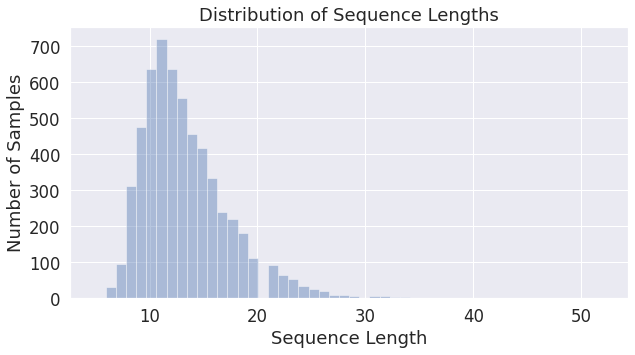

In [ ]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(lengths, kde=False, rug=False)

plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Samples')

plt.show()

In [ ]:
np.quantile(lengths, 0.95) 

21.0

Conclusion: 95% of our data are <= 21 tokens long, thus ``max_seq_len = 32`` will suit us right.

## ``DeepPavlov/rubert-base-cased``

In [ ]:
import yaml

with open("/content/config.yml", "r") as yamlfile:
    cfg = yaml.safe_load(yamlfile)
    print("Read successful")
print(cfg)

Read successful
{'data': {'labeled_df_filename': '/content/dataset/train.tsv', 'unlabeled_df_filename': '/content/dataset/test.tsv', 'train_size': 0.9, 'val_size': 0.1}, 'model': {'model_name': 'DeepPavlov/rubert-base-cased', 'max_seq_length': 32, 'num_classes': 2, 'dropout': 0.25}, 'training': {'learning_rate': '3e-5', 'adam_epsilon': '1e-8', 'num_epochs': 15, 'batch_size': 16}, 'general': {'seed': 42}}


In [ ]:
from data import read_data

In [ ]:
train_dataloader, val_dataloader, unlabeled_dataloader = read_data(cfg)

In [ ]:
from model import BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification(
    pretrained_model_name='DeepPavlov/rubert-base-cased',
    num_labels=cfg['model']['num_classes'], # 2
    dropout=cfg['model']['dropout'], # 0.25
)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from train import run, eval_loop_fn, infer_loop_fn

wandb: Currently logged in as: korablev (use `wandb login --relogin` to force relogin)


In [ ]:
# storing our errors & scores for further plt.plotting
train_losses = []
val_losses = []
F1_scores = []
accuracy_scores = []

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch = 0


Validating: 100%|██████████| 36/36 [00:04<00:00,  8.49it/s]


Validation acc = 0.9444444444444444; F1 = 0.9444766505636072
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       272
           1       0.96      0.93      0.95       304

    accuracy                           0.94       576
   macro avg       0.94      0.95      0.94       576
weighted avg       0.94      0.94      0.94       576

AxesSubplot(0.125,0.125;0.62x0.755)


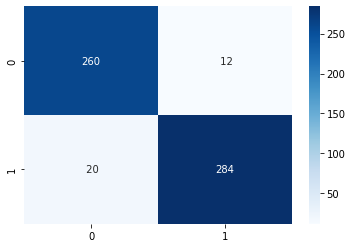

=> Saving checkpoint at epoch 0


  7%|▋         | 1/15 [02:07<29:41, 127.26s/it]

Epoch = 1


 13%|█▎        | 2/15 [03:59<25:39, 118.45s/it]

Validation acc = 0.9166666666666666; F1 = 0.9166495866639338
Epoch = 2


 20%|██        | 3/15 [05:53<23:16, 116.41s/it]

Validation acc = 0.9392361111111112; F1 = 0.9392020884679939
Epoch = 3


 27%|██▋       | 4/15 [07:44<20:58, 114.38s/it]

Validation acc = 0.9409722222222222; F1 = 0.9409722222222222
Epoch = 4


 33%|███▎      | 5/15 [09:49<19:39, 117.98s/it]

Validation acc = 0.9288194444444444; F1 = 0.9288639259793716
Epoch = 5


 40%|████      | 6/15 [11:41<17:24, 116.02s/it]

Validation acc = 0.9253472222222222; F1 = 0.925127465127465
Epoch = 6


 47%|████▋     | 7/15 [13:33<15:16, 114.61s/it]

Validation acc = 0.9097222222222222; F1 = 0.9096830372692443
Epoch = 7


 53%|█████▎    | 8/15 [15:25<13:16, 113.81s/it]

Validation acc = 0.9392361111111112; F1 = 0.939278474454354
Epoch = 8


 60%|██████    | 9/15 [17:17<11:19, 113.31s/it]

Validation acc = 0.9444444444444444; F1 = 0.9444766505636072
Epoch = 9


 67%|██████▋   | 10/15 [19:09<09:25, 113.05s/it]

Validation acc = 0.9392361111111112; F1 = 0.939278474454354
Epoch = 10


 73%|███████▎  | 11/15 [21:01<07:31, 112.76s/it]

Validation acc = 0.9409722222222222; F1 = 0.9410064412238326
Epoch = 11


 80%|████████  | 12/15 [22:53<05:37, 112.50s/it]

Validation acc = 0.9409722222222222; F1 = 0.9410149732562942
Epoch = 12


 87%|████████▋ | 13/15 [24:45<03:44, 112.39s/it]

Validation acc = 0.9392361111111112; F1 = 0.9392168093745157
Epoch = 13


 93%|█████████▎| 14/15 [26:37<01:52, 112.27s/it]

Validation acc = 0.9427083333333334; F1 = 0.9427026160689714
Epoch = 14


100%|██████████| 15/15 [28:29<00:00, 113.98s/it]

Validation acc = 0.9392361111111112; F1 = 0.9392520854212728


In [ ]:
run(model=model,
    cfg=cfg,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    train_losses=train_losses,
    val_losses=val_losses,
    F1_scores=F1_scores,
    accuracy_scores=accuracy_scores,
)

In [ ]:
best_checkpoint = torch.load('/content/best_f1_state.pth')

In [ ]:
print(best_checkpoint['epoch'],best_checkpoint['accuracy'],best_checkpoint['F1_score'])

0 0.9444444444444444 0.9444766505636072


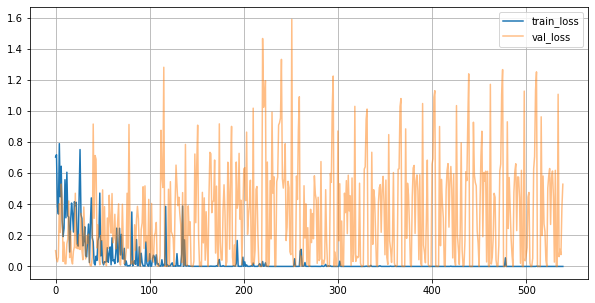

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss',alpha=0.5)
plt.legend(loc='best')
plt.grid()

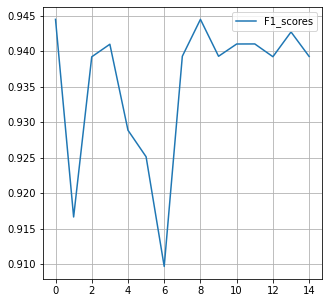

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(F1_scores, label='F1_scores')
plt.legend(loc='best')
plt.grid()

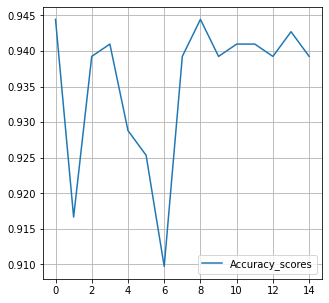

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(accuracy_scores, label='Accuracy_scores')
plt.legend(loc='best')
plt.grid()

To run inference on ``unlabeled_dataset``

In [ ]:
device = torch.device("cuda")
model.load_state_dict(best_checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
predicted_labels = infer_loop_fn(unlabeled_dataloader, model, device)
best_predictions_df = pd.DataFrame(predicted_labels)
#best_predictions_df.to_csv('best_predictions_df', sep='\t', encoding='utf-8')
#best_predictions_df.to_excel("best_predictions_df.xlsx")

Inference: 100%|██████████| 63/63 [00:06<00:00, 10.32it/s]


In [ ]:
best_predictions_df.head(10)

,0
0,1
1,1
2,1
3,1
4,1
5,0
6,0
7,0
8,0
9,0


In [ ]:
unlabeled_df["is_fake"].head(5)

0    0
1    0
2    0
3    0
4    0
Name: is_fake, dtype: int64

In [ ]:
# adding these labels to predictions.tsv
unlabeled_df["is_fake"] = predicted_labels
unlabeled_df["is_fake"].head(15)

0     1
1     1
2     1
3     1
4     1
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    0
13    0
14    0
Name: is_fake, dtype: int64

In [ ]:
unlabeled_df["is_fake"].to_csv('predictions.tsv', sep="\t")

In [ ]:
unlabeled_df["is_fake"].to_excel('predictions.xlsx')

## ``DeepPavlov/rubert-base-cased-sentence``

In [ ]:
# basically the same config, but model_name: DeepPavlov/rubert-base-cased-sentence   
import yaml

with open("/content/config.yml", "r") as yamlfile:
    cfg = yaml.safe_load(yamlfile)
    print("Read successful")
print(cfg)

Read successful
{'data': {'labeled_df_filename': '/content/dataset/train.tsv', 'unlabeled_df_filename': '/content/dataset/test.tsv', 'train_size': 0.9, 'val_size': 0.1}, 'model': {'model_name': 'DeepPavlov/rubert-base-cased-sentence', 'max_seq_length': 32, 'num_classes': 2, 'dropout': 0.25}, 'training': {'learning_rate': '3e-5', 'adam_epsilon': '1e-8', 'num_epochs': 20, 'batch_size': 16}, 'general': {'seed': 42}}


In [ ]:
from data import read_data

In [ ]:
train_dataloader, val_dataloader, unlabeled_dataloader = read_data(cfg)

In [ ]:
from model import BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification(
    pretrained_model_name='DeepPavlov/rubert-base-cased-sentence',
    num_labels=cfg['model']['num_classes'], # 2
    dropout=cfg['model']['dropout'], # 0.25
)

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/678M [00:00<?, ?B/s]

In [ ]:
# storing our errors & scores for further plt.plotting
train_losses = []
val_losses = []
F1_scores = []
accuracy_scores = []

In [ ]:
from train import run, eval_loop_fn, infer_loop_fn

wandb: Currently logged in as: korablev (use `wandb login --relogin` to force relogin)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch = 0


Validating: 100%|██████████| 36/36 [00:05<00:00,  6.42it/s]


Validation acc = 0.9392361111111112; F1 = 0.939274083153122
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       272
           1       0.96      0.93      0.94       304

    accuracy                           0.94       576
   macro avg       0.94      0.94      0.94       576
weighted avg       0.94      0.94      0.94       576

AxesSubplot(0.125,0.125;0.62x0.755)


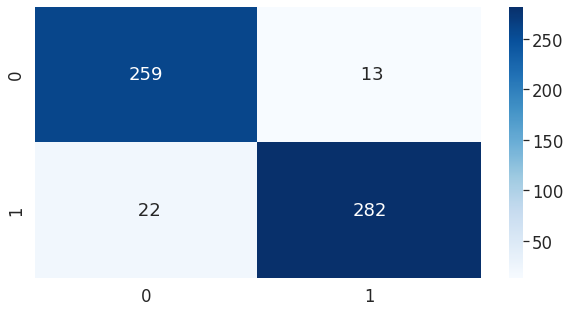

=> Saving checkpoint at epoch 0


  5%|▌         | 1/20 [02:10<41:25, 130.82s/it]

Epoch = 1


 10%|█         | 2/20 [04:02<35:57, 119.84s/it]

Validation acc = 0.9392361111111112; F1 = 0.9390572390572393
Epoch = 2


 15%|█▌        | 3/20 [05:55<32:56, 116.27s/it]

Validation acc = 0.9288194444444444; F1 = 0.9288690221934104
Epoch = 3


 20%|██        | 4/20 [07:47<30:33, 114.60s/it]

Validation acc = 0.921875; F1 = 0.9219237552570887
Epoch = 4


 25%|██▌       | 5/20 [09:39<28:25, 113.71s/it]

Validation acc = 0.9340277777777778; F1 = 0.933943816184462
Epoch = 5


Validating: 100%|██████████| 36/36 [00:04<00:00,  8.54it/s]


Validation acc = 0.9444444444444444; F1 = 0.9444632431532417
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       272
           1       0.95      0.94      0.95       304

    accuracy                           0.94       576
   macro avg       0.94      0.94      0.94       576
weighted avg       0.94      0.94      0.94       576

AxesSubplot(0.125,0.125;0.62x0.755)


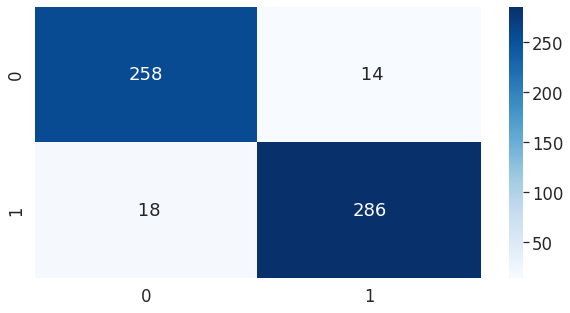

=> Saving checkpoint at epoch 5


 30%|███       | 6/20 [11:48<27:48, 119.15s/it]

Epoch = 6


 35%|███▌      | 7/20 [13:44<25:33, 117.95s/it]

Validation acc = 0.9201388888888888; F1 = 0.9201995831406532
Epoch = 7


 40%|████      | 8/20 [15:39<23:25, 117.10s/it]

Validation acc = 0.9201388888888888; F1 = 0.9201533315382585
Epoch = 8


 45%|████▌     | 9/20 [17:34<21:22, 116.56s/it]

Validation acc = 0.9288194444444444; F1 = 0.9288639259793716
Epoch = 9


 50%|█████     | 10/20 [19:30<19:22, 116.28s/it]

Validation acc = 0.9288194444444444; F1 = 0.9288484100692654
Epoch = 10


 55%|█████▌    | 11/20 [21:25<17:23, 115.89s/it]

Validation acc = 0.9340277777777778; F1 = 0.9340779165074962
Epoch = 11


 60%|██████    | 12/20 [23:20<15:25, 115.63s/it]

Validation acc = 0.9357638888888888; F1 = 0.9358132936813139
Epoch = 12


 65%|██████▌   | 13/20 [25:15<13:28, 115.50s/it]

Validation acc = 0.9375; F1 = 0.9375415041715465
Epoch = 13


 70%|███████   | 14/20 [27:11<11:32, 115.42s/it]

Validation acc = 0.9375; F1 = 0.9375294472968894
Epoch = 14


 75%|███████▌  | 15/20 [29:06<09:37, 115.43s/it]

Validation acc = 0.9375; F1 = 0.9375294472968894
Epoch = 15


 80%|████████  | 16/20 [31:02<07:41, 115.46s/it]

Validation acc = 0.9409722222222222; F1 = 0.9409722222222222
Epoch = 16


 85%|████████▌ | 17/20 [32:57<05:45, 115.30s/it]

Validation acc = 0.9409722222222222; F1 = 0.940982926131441
Epoch = 17


 90%|█████████ | 18/20 [34:53<03:51, 115.71s/it]

Validation acc = 0.9357638888888888; F1 = 0.9357978350930208
Epoch = 18


 95%|█████████▌| 19/20 [36:49<01:55, 115.65s/it]

Validation acc = 0.9357638888888888; F1 = 0.9357978350930208
Epoch = 19


100%|██████████| 20/20 [38:44<00:00, 116.23s/it]

Validation acc = 0.9357638888888888; F1 = 0.9357978350930208


In [ ]:
run(model=model,
    cfg=cfg,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    train_losses=train_losses,
    val_losses=val_losses,
    F1_scores=F1_scores,
    accuracy_scores=accuracy_scores,
)

In [ ]:
best_checkpoint = torch.load('/content/best_f1_state.pth')

In [ ]:
print(best_checkpoint['epoch'],best_checkpoint['accuracy'],best_checkpoint['F1_score'])

5 0.9444444444444444 0.9444632431532417


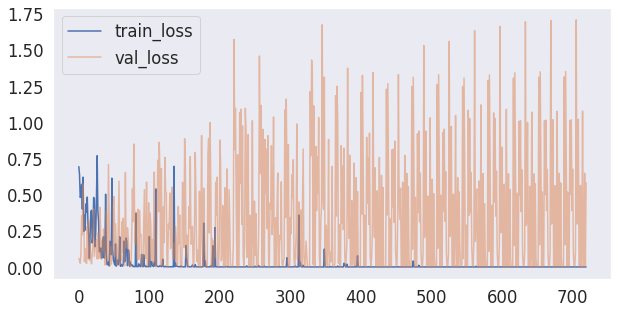

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss', alpha=0.5)
plt.legend(loc='best')
plt.grid()

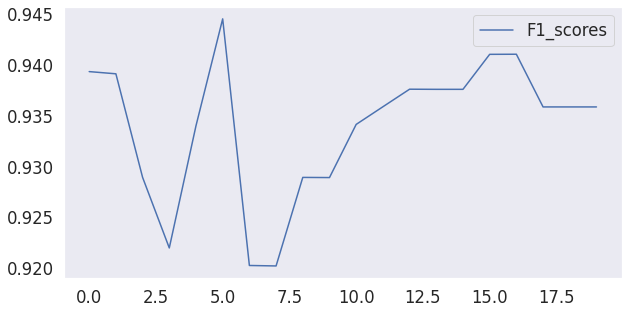

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(F1_scores, label='F1_scores')
plt.legend(loc='best')
plt.grid()

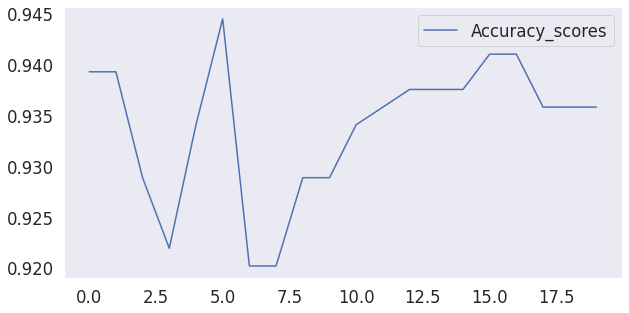

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(accuracy_scores, label='Accuracy_scores')
plt.legend(loc='best')
plt.grid()

## ``DeepPavlov/bert-base-multilingual-cased-sentence``

In [ ]:
# basically the same config, but model_name: DeepPavlov/bert-base-multilingual-cased-sentence
import yaml

with open("/content/config.yml", "r") as yamlfile:
    cfg = yaml.safe_load(yamlfile)
    print("Read successful")
print(cfg)

Read successful
{'data': {'labeled_df_filename': '/content/dataset/train.tsv', 'unlabeled_df_filename': '/content/dataset/test.tsv', 'train_size': 0.9, 'val_size': 0.1}, 'model': {'model_name': 'DeepPavlov/bert-base-multilingual-cased-sentence', 'max_seq_length': 32, 'num_classes': 2, 'dropout': 0.25}, 'training': {'learning_rate': '3e-5', 'adam_epsilon': '1e-8', 'num_epochs': 10, 'batch_size': 16}, 'general': {'seed': 42}}


In [ ]:
from data import read_data

In [ ]:
train_dataloader, val_dataloader, unlabeled_dataloader = read_data(cfg)

In [ ]:
from model import BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification(
    pretrained_model_name='DeepPavlov/bert-base-multilingual-cased-sentence',
    num_labels=cfg['model']['num_classes'], # 2
    dropout=cfg['model']['dropout'], # 0.25
)

Downloading:   0%|          | 0.00/678M [00:00<?, ?B/s]

In [ ]:
# storing our errors & scores for further plt.plotting
train_losses = []
val_losses = []
F1_scores = []
accuracy_scores = []

In [ ]:
from train import run, eval_loop_fn, infer_loop_fn

wandb: Currently logged in as: korablev (use `wandb login --relogin` to force relogin)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch = 0


Validating: 100%|██████████| 36/36 [00:02<00:00, 14.22it/s]


Validation acc = 0.8975694444444444; F1 = 0.89762357487806
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       272
           1       0.91      0.89      0.90       304

    accuracy                           0.90       576
   macro avg       0.90      0.90      0.90       576
weighted avg       0.90      0.90      0.90       576

AxesSubplot(0.125,0.125;0.62x0.755)


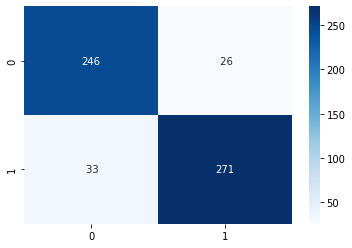

=> Saving checkpoint at epoch 0


 10%|█         | 1/10 [01:52<16:49, 112.21s/it]

Epoch = 1


Validating: 100%|██████████| 36/36 [00:02<00:00, 14.37it/s]


Validation acc = 0.9236111111111112; F1 = 0.9235778261922051
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       272
           1       0.92      0.93      0.93       304

    accuracy                           0.92       576
   macro avg       0.92      0.92      0.92       576
weighted avg       0.92      0.92      0.92       576

AxesSubplot(0.125,0.125;0.62x0.755)


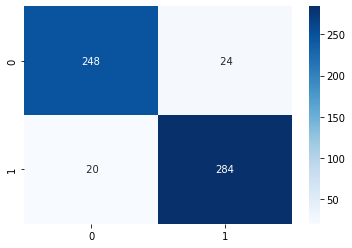

=> Saving checkpoint at epoch 1


 20%|██        | 2/10 [03:43<14:53, 111.69s/it]

Epoch = 2


 30%|███       | 3/10 [05:21<12:18, 105.43s/it]

Validation acc = 0.8993055555555556; F1 = 0.8990708365708365
Epoch = 3


 40%|████      | 4/10 [06:59<10:14, 102.49s/it]

Validation acc = 0.9114583333333334; F1 = 0.9113593561449481
Epoch = 4


 50%|█████     | 5/10 [08:37<08:24, 100.89s/it]

Validation acc = 0.9114583333333334; F1 = 0.9114302079457229
Epoch = 5


 60%|██████    | 6/10 [10:15<06:39, 99.92s/it] 

Validation acc = 0.9131944444444444; F1 = 0.9132238174269401
Epoch = 6


 70%|███████   | 7/10 [11:53<04:57, 99.29s/it]

Validation acc = 0.9166666666666666; F1 = 0.9166091487755753
Epoch = 7


 80%|████████  | 8/10 [13:31<03:17, 98.92s/it]

Validation acc = 0.9201388888888888; F1 = 0.9201765159904696
Epoch = 8


 90%|█████████ | 9/10 [15:09<01:38, 98.63s/it]

Validation acc = 0.9166666666666666; F1 = 0.9167149012798252
Epoch = 9


100%|██████████| 10/10 [16:47<00:00, 100.77s/it]

Validation acc = 0.9131944444444444; F1 = 0.9131765907823013


In [ ]:
run(model=model,
    cfg=cfg,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    train_losses=train_losses,
    val_losses=val_losses,
    F1_scores=F1_scores,
    accuracy_scores=accuracy_scores,
)

In [ ]:
best_checkpoint = torch.load('/content/best_f1_state.pth')

In [ ]:
print(best_checkpoint['epoch'],best_checkpoint['accuracy'],best_checkpoint['F1_score'])

1 0.9236111111111112 0.9235778261922051


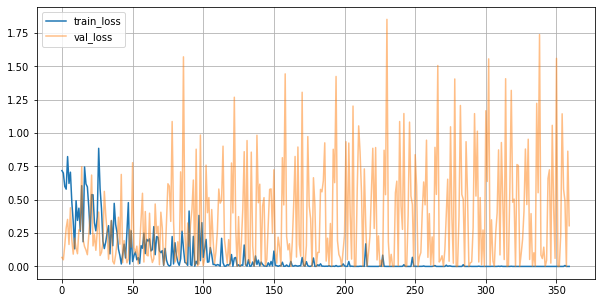

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss', alpha=0.5)
plt.legend(loc='best')
plt.grid()

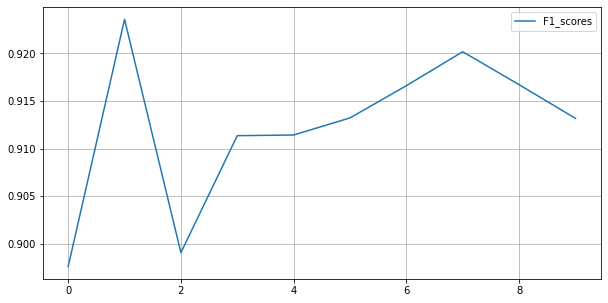

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(F1_scores, label='F1_scores')
plt.legend(loc='best')
plt.grid()

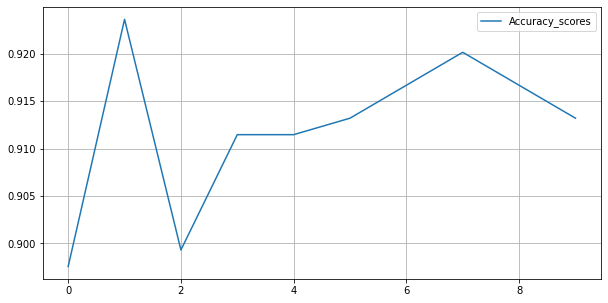

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(accuracy_scores, label='Accuracy_scores')
plt.legend(loc='best')
plt.grid()

## ``bert-base-multilingual-cased``

In [ ]:
# basically the same config, but model_name: bert-base-multilingual-cased
import yaml

with open("/content/config.yml", "r") as yamlfile:
    cfg = yaml.safe_load(yamlfile)
    print("Read successful")
print(cfg)

Read successful
{'data': {'labeled_df_filename': '/content/dataset/train.tsv', 'unlabeled_df_filename': '/content/dataset/test.tsv', 'train_size': 0.9, 'val_size': 0.1}, 'model': {'model_name': 'bert-base-multilingual-cased', 'max_seq_length': 32, 'num_classes': 2, 'dropout': 0.25}, 'training': {'learning_rate': '3e-5', 'adam_epsilon': '1e-8', 'num_epochs': 20, 'batch_size': 16}, 'general': {'seed': 42}}


In [ ]:
from data import read_data

In [ ]:
train_dataloader, val_dataloader, unlabeled_dataloader = read_data(cfg)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

In [ ]:
from model import BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification(
    pretrained_model_name='bert-base-multilingual-cased',
    num_labels=cfg['model']['num_classes'], # 2
    dropout=cfg['model']['dropout'], # 0.25
)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# storing our errors & scores for further plt.plotting
train_losses = []
val_losses = []
F1_scores = []
accuracy_scores = []

In [ ]:
from train import run, eval_loop_fn, infer_loop_fn

wandb: Currently logged in as: korablev (use `wandb login --relogin` to force relogin)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch = 0


Validating: 100%|██████████| 36/36 [00:02<00:00, 14.46it/s]


Validation acc = 0.890625; F1 = 0.890534586910115
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       272
           1       0.89      0.91      0.90       304

    accuracy                           0.89       576
   macro avg       0.89      0.89      0.89       576
weighted avg       0.89      0.89      0.89       576

AxesSubplot(0.125,0.125;0.62x0.755)


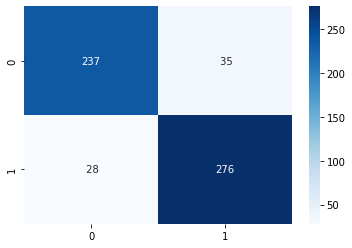

=> Saving checkpoint at epoch 0


  5%|▌         | 1/20 [01:53<35:52, 113.31s/it]

Epoch = 1


Validating: 100%|██████████| 36/36 [00:02<00:00, 14.45it/s]


Validation acc = 0.90625; F1 = 0.9055484912212061
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       272
           1       0.87      0.97      0.92       304

    accuracy                           0.91       576
   macro avg       0.91      0.90      0.90       576
weighted avg       0.91      0.91      0.91       576

AxesSubplot(0.125,0.125;0.62x0.755)


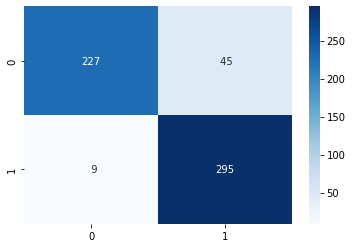

=> Saving checkpoint at epoch 1


 10%|█         | 2/20 [03:43<33:30, 111.69s/it]

Epoch = 2


 15%|█▌        | 3/20 [05:21<29:51, 105.37s/it]

Validation acc = 0.8888888888888888; F1 = 0.8889746889746889
Epoch = 3


Validating: 100%|██████████| 36/36 [00:02<00:00, 14.33it/s]


Validation acc = 0.9184027777777778; F1 = 0.9184458986316749
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       272
           1       0.93      0.91      0.92       304

    accuracy                           0.92       576
   macro avg       0.92      0.92      0.92       576
weighted avg       0.92      0.92      0.92       576

AxesSubplot(0.125,0.125;0.62x0.755)


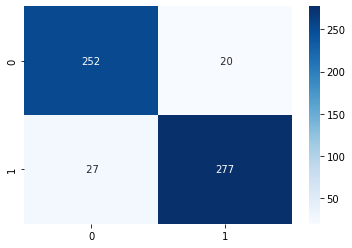

=> Saving checkpoint at epoch 3


 20%|██        | 4/20 [07:12<28:40, 107.50s/it]

Epoch = 4


 25%|██▌       | 5/20 [08:50<26:00, 104.04s/it]

Validation acc = 0.9010416666666666; F1 = 0.9010509398505712
Epoch = 5


 30%|███       | 6/20 [10:28<23:47, 101.99s/it]

Validation acc = 0.9079861111111112; F1 = 0.9080236341063355
Epoch = 6


 35%|███▌      | 7/20 [12:06<21:48, 100.65s/it]

Validation acc = 0.9149305555555556; F1 = 0.9149220662842303
Epoch = 7


 40%|████      | 8/20 [13:44<19:57, 99.77s/it] 

Validation acc = 0.90625; F1 = 0.9061591393680946
Epoch = 8


 45%|████▌     | 9/20 [15:21<18:10, 99.15s/it]

Validation acc = 0.9097222222222222; F1 = 0.9097908596116481
Epoch = 9


 50%|█████     | 10/20 [16:59<16:27, 98.76s/it]

Validation acc = 0.9079861111111112; F1 = 0.9080236341063355
Epoch = 10


 55%|█████▌    | 11/20 [18:37<14:46, 98.49s/it]

Validation acc = 0.9149305555555556; F1 = 0.9149939568885603
Epoch = 11


 60%|██████    | 12/20 [20:15<13:06, 98.30s/it]

Validation acc = 0.9166666666666666; F1 = 0.9167149758454107
Epoch = 12


 65%|██████▌   | 13/20 [21:53<11:27, 98.15s/it]

Validation acc = 0.9045138888888888; F1 = 0.9045850536504249
Epoch = 13


Validating: 100%|██████████| 36/36 [00:02<00:00, 14.52it/s]


Validation acc = 0.9201388888888888; F1 = 0.9201388888888888
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       272
           1       0.92      0.92      0.92       304

    accuracy                           0.92       576
   macro avg       0.92      0.92      0.92       576
weighted avg       0.92      0.92      0.92       576

AxesSubplot(0.125,0.125;0.62x0.755)


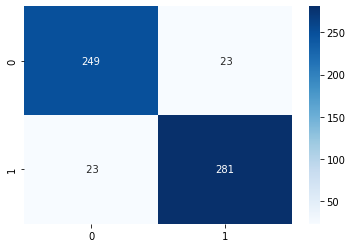

=> Saving checkpoint at epoch 13


 70%|███████   | 14/20 [23:44<10:11, 101.93s/it]

Epoch = 14


 75%|███████▌  | 15/20 [25:22<08:23, 100.74s/it]

Validation acc = 0.9097222222222222; F1 = 0.9097745571658614
Epoch = 15


 80%|████████  | 16/20 [26:59<06:39, 99.90s/it] 

Validation acc = 0.9097222222222222; F1 = 0.9097821726922339
Epoch = 16


 85%|████████▌ | 17/20 [28:38<04:57, 99.33s/it]

Validation acc = 0.8993055555555556; F1 = 0.8993638390464554
Epoch = 17


 90%|█████████ | 18/20 [30:17<03:18, 99.24s/it]

Validation acc = 0.9045138888888888; F1 = 0.9045735592406204
Epoch = 18


 95%|█████████▌| 19/20 [31:54<01:38, 98.79s/it]

Validation acc = 0.9045138888888888; F1 = 0.9045850536504249
Epoch = 19


100%|██████████| 20/20 [33:32<00:00, 100.62s/it]

Validation acc = 0.9045138888888888; F1 = 0.9045389913762859


In [ ]:
run(model=model,
    cfg=cfg,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    train_losses=train_losses,
    val_losses=val_losses,
    F1_scores=F1_scores,
    accuracy_scores=accuracy_scores,
)

In [ ]:
best_checkpoint = torch.load('/content/best_f1_state.pth')

In [ ]:
print(best_checkpoint['epoch'],best_checkpoint['accuracy'],best_checkpoint['F1_score'])

13 0.9201388888888888 0.9201388888888888


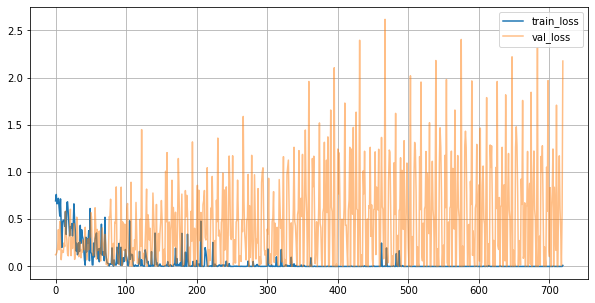

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss', alpha=0.5)
plt.legend(loc='best')
plt.grid()

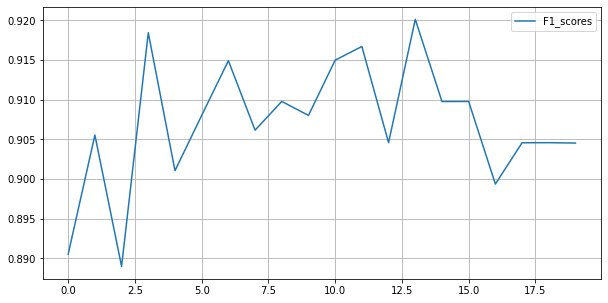

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(F1_scores, label='F1_scores')
plt.legend(loc='best')
plt.grid()

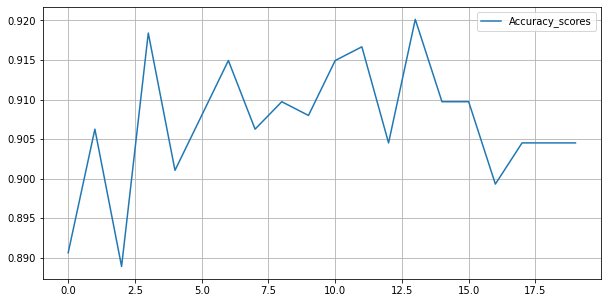

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(accuracy_scores, label='Accuracy_scores')
plt.legend(loc='best')
plt.grid()

##``bert-base-multilingual-uncased``

In [ ]:
# basically the same config, but model_name: bert-base-multilingual-uncased
import yaml

with open("/content/config.yml", "r") as yamlfile:
    cfg = yaml.safe_load(yamlfile)
    print("Read successful")
print(cfg)

Read successful
{'data': {'labeled_df_filename': '/content/dataset/train.tsv', 'unlabeled_df_filename': '/content/dataset/test.tsv', 'train_size': 0.9, 'val_size': 0.1}, 'model': {'model_name': 'bert-base-multilingual-uncased', 'max_seq_length': 32, 'num_classes': 2, 'dropout': 0.25}, 'training': {'learning_rate': '3e-5', 'adam_epsilon': '1e-8', 'num_epochs': 20, 'batch_size': 16}, 'general': {'seed': 42}}


In [ ]:
from data import read_data

In [ ]:
train_dataloader, val_dataloader, unlabeled_dataloader = read_data(cfg)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

In [ ]:
from model import BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification(
    pretrained_model_name='bert-base-multilingual-uncased',
    num_labels=cfg['model']['num_classes'], # 2
    dropout=cfg['model']['dropout'], # 0.25
)

Downloading:   0%|          | 0.00/641M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# storing our errors & scores for further plt.plotting
train_losses = []
val_losses = []
F1_scores = []
accuracy_scores = []

In [ ]:
from train import run, eval_loop_fn, infer_loop_fn

wandb: Currently logged in as: korablev (use `wandb login --relogin` to force relogin)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch = 0


Validating: 100%|██████████| 36/36 [00:02<00:00, 14.36it/s]


Validation acc = 0.9079861111111112; F1 = 0.9075869969084225
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       272
           1       0.88      0.95      0.92       304

    accuracy                           0.91       576
   macro avg       0.91      0.91      0.91       576
weighted avg       0.91      0.91      0.91       576

AxesSubplot(0.125,0.125;0.62x0.755)


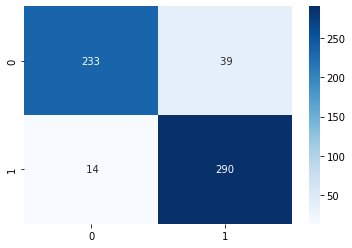

=> Saving checkpoint at epoch 0


  5%|▌         | 1/20 [01:48<34:17, 108.27s/it]

Epoch = 1


 10%|█         | 2/20 [03:24<30:19, 101.07s/it]

Validation acc = 0.8923611111111112; F1 = 0.8923143905902526
Epoch = 2


 15%|█▌        | 3/20 [05:00<27:58, 98.76s/it] 

Validation acc = 0.8888888888888888; F1 = 0.8885871860782254
Epoch = 3


 20%|██        | 4/20 [06:36<26:02, 97.65s/it]

Validation acc = 0.9045138888888888; F1 = 0.9045642618444953
Epoch = 4


 25%|██▌       | 5/20 [08:12<24:15, 97.03s/it]

Validation acc = 0.8888888888888888; F1 = 0.8887817008596479
Epoch = 5


Validating: 100%|██████████| 36/36 [00:02<00:00, 14.40it/s]


Validation acc = 0.9184027777777778; F1 = 0.918376858302921
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       272
           1       0.92      0.93      0.92       304

    accuracy                           0.92       576
   macro avg       0.92      0.92      0.92       576
weighted avg       0.92      0.92      0.92       576

AxesSubplot(0.125,0.125;0.62x0.755)


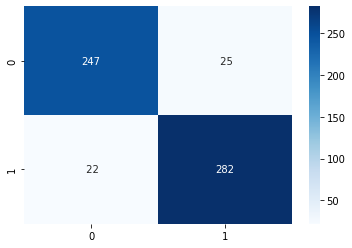

=> Saving checkpoint at epoch 5


 30%|███       | 6/20 [10:00<23:30, 100.74s/it]

Epoch = 6


 35%|███▌      | 7/20 [11:36<21:29, 99.19s/it] 

Validation acc = 0.8958333333333334; F1 = 0.8958684993167751
Epoch = 7


Validating: 100%|██████████| 36/36 [00:02<00:00, 14.27it/s]


Validation acc = 0.9201388888888888; F1 = 0.9201851851851851
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       272
           1       0.94      0.91      0.92       304

    accuracy                           0.92       576
   macro avg       0.92      0.92      0.92       576
weighted avg       0.92      0.92      0.92       576

AxesSubplot(0.125,0.125;0.62x0.755)


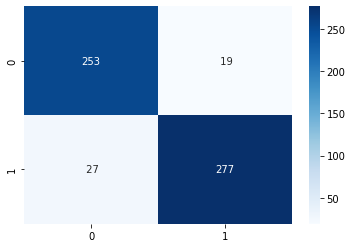

=> Saving checkpoint at epoch 7


 40%|████      | 8/20 [13:24<20:25, 102.10s/it]

Epoch = 8


 45%|████▌     | 9/20 [15:00<18:22, 100.22s/it]

Validation acc = 0.9201388888888888; F1 = 0.9201765159904696
Epoch = 9


 50%|█████     | 10/20 [16:36<16:28, 98.84s/it]

Validation acc = 0.9079861111111112; F1 = 0.9080236341063355
Epoch = 10


 55%|█████▌    | 11/20 [18:12<14:41, 97.90s/it]

Validation acc = 0.9097222222222222; F1 = 0.9097821032841957
Epoch = 11


 60%|██████    | 12/20 [19:47<12:58, 97.26s/it]

Validation acc = 0.8993055555555556; F1 = 0.89928491721892
Epoch = 12


 65%|██████▌   | 13/20 [21:23<11:17, 96.83s/it]

Validation acc = 0.9131944444444444; F1 = 0.9131765907823013
Epoch = 13


 70%|███████   | 14/20 [23:01<09:42, 97.13s/it]

Validation acc = 0.9097222222222222; F1 = 0.9097745571658614
Epoch = 14


 75%|███████▌  | 15/20 [24:37<08:03, 96.79s/it]

Validation acc = 0.90625; F1 = 0.9063042639398032
Epoch = 15


 80%|████████  | 16/20 [26:13<06:26, 96.51s/it]

Validation acc = 0.9131944444444444; F1 = 0.9132614757614758
Epoch = 16


 85%|████████▌ | 17/20 [27:49<04:48, 96.29s/it]

Validation acc = 0.9184027777777778; F1 = 0.918410424087313
Epoch = 17


 90%|█████████ | 18/20 [29:25<03:12, 96.16s/it]

Validation acc = 0.9114583333333334; F1 = 0.9114944403664738
Epoch = 18


 95%|█████████▌| 19/20 [31:00<01:36, 96.06s/it]

Validation acc = 0.9131944444444444; F1 = 0.913244766505636
Epoch = 19


100%|██████████| 20/20 [32:36<00:00, 97.83s/it]

Validation acc = 0.9079861111111112; F1 = 0.9080236341063355


In [ ]:
run(model=model,
    cfg=cfg,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    train_losses=train_losses,
    val_losses=val_losses,
    F1_scores=F1_scores,
    accuracy_scores=accuracy_scores,
)

In [ ]:
best_checkpoint = torch.load('/content/best_f1_state.pth')

In [ ]:
print(best_checkpoint['epoch'],best_checkpoint['accuracy'],best_checkpoint['F1_score'])

7 0.9201388888888888 0.9201851851851851


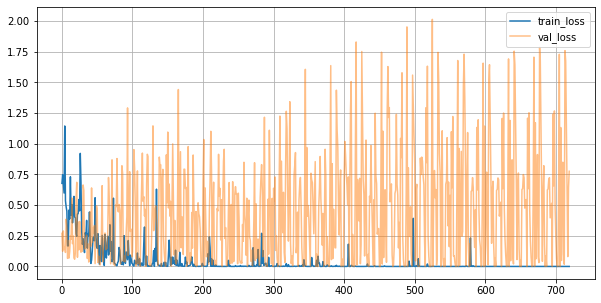

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss', alpha=0.5)
plt.legend(loc='best')
plt.grid()

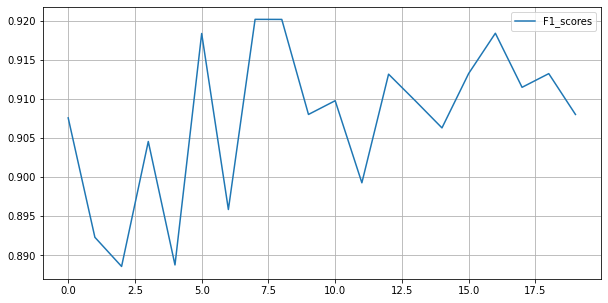

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(F1_scores, label='F1_scores')
plt.legend(loc='best')
plt.grid()

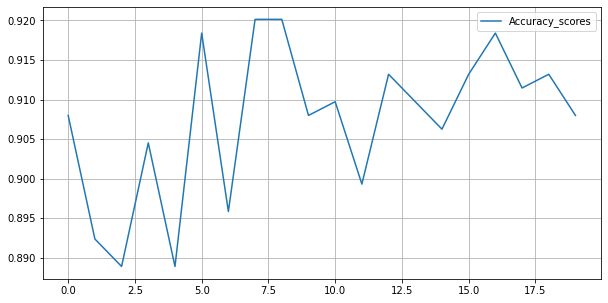

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(accuracy_scores, label='Accuracy_scores')
plt.legend(loc='best')
plt.grid()

## ``cointegrated/rubert-tiny``

In [ ]:
# basically the same config, but model_name: cointegrated/rubert-tiny
import yaml

with open("/content/config.yml", "r") as yamlfile:
    cfg = yaml.safe_load(yamlfile)
    print("Read successful")
print(cfg)

Read successful
{'data': {'labeled_df_filename': '/content/dataset/train.tsv', 'unlabeled_df_filename': '/content/dataset/test.tsv', 'train_size': 0.9, 'val_size': 0.1}, 'model': {'model_name': 'cointegrated/rubert-tiny', 'max_seq_length': 32, 'num_classes': 2, 'dropout': 0.25}, 'training': {'learning_rate': '3e-5', 'adam_epsilon': '1e-8', 'num_epochs': 20, 'batch_size': 16}, 'general': {'seed': 42}}


In [ ]:
from data import read_data

In [ ]:
train_dataloader, val_dataloader, unlabeled_dataloader = read_data(cfg)

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/457k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
from model import BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification(
    pretrained_model_name='cointegrated/rubert-tiny',
    num_labels=cfg['model']['num_classes'], # 2
    dropout=cfg['model']['dropout'], # 0.25
)

Downloading:   0%|          | 0.00/45.5M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# storing our errors & scores for further plt.plotting
train_losses = []
val_losses = []
F1_scores = []
accuracy_scores = []

In [ ]:
from train import run, eval_loop_fn, infer_loop_fn

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch = 0


Validating: 100%|██████████| 36/36 [00:00<00:00, 73.30it/s]


Validation acc = 0.8697916666666666; F1 = 0.8698730353281188
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       272
           1       0.89      0.86      0.87       304

    accuracy                           0.87       576
   macro avg       0.87      0.87      0.87       576
weighted avg       0.87      0.87      0.87       576

AxesSubplot(0.125,0.125;0.62x0.755)


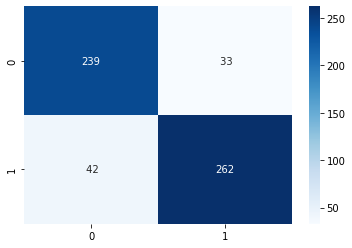

=> Saving checkpoint at epoch 0


  5%|▌         | 1/20 [00:15<04:46, 15.09s/it]

Epoch = 1


 10%|█         | 2/20 [00:33<05:04, 16.93s/it]

Validation acc = 0.8663194444444444; F1 = 0.8661277932525815
Epoch = 2


Validating: 100%|██████████| 36/36 [00:01<00:00, 30.19it/s]


Validation acc = 0.8732638888888888; F1 = 0.8728351003123245
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       272
           1       0.86      0.91      0.88       304

    accuracy                           0.87       576
   macro avg       0.88      0.87      0.87       576
weighted avg       0.87      0.87      0.87       576

AxesSubplot(0.125,0.125;0.62x0.755)


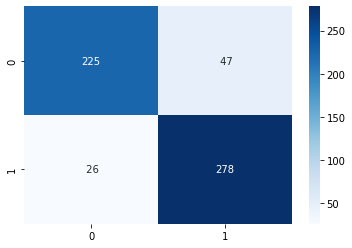

=> Saving checkpoint at epoch 2


 15%|█▌        | 3/20 [00:54<05:20, 18.85s/it]

Epoch = 3


Validating: 100%|██████████| 36/36 [00:01<00:00, 28.08it/s]


Validation acc = 0.8888888888888888; F1 = 0.8888888888888888
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       272
           1       0.89      0.89      0.89       304

    accuracy                           0.89       576
   macro avg       0.89      0.89      0.89       576
weighted avg       0.89      0.89      0.89       576

AxesSubplot(0.125,0.125;0.62x0.755)


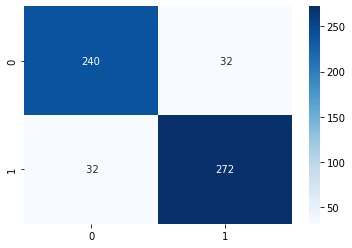

=> Saving checkpoint at epoch 3


 20%|██        | 4/20 [01:18<05:34, 20.92s/it]

Epoch = 4


 25%|██▌       | 5/20 [01:39<05:12, 20.86s/it]

Validation acc = 0.8819444444444444; F1 = 0.8816692566692566
Epoch = 5


Validating: 100%|██████████| 36/36 [00:01<00:00, 28.89it/s]


Validation acc = 0.9010416666666666; F1 = 0.9011177767522945
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       272
           1       0.93      0.88      0.90       304

    accuracy                           0.90       576
   macro avg       0.90      0.90      0.90       576
weighted avg       0.90      0.90      0.90       576

AxesSubplot(0.125,0.125;0.62x0.755)


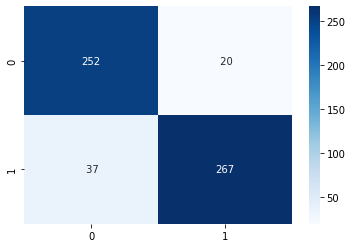

=> Saving checkpoint at epoch 5


 30%|███       | 6/20 [02:03<05:06, 21.87s/it]

Epoch = 6


 35%|███▌      | 7/20 [02:23<04:39, 21.50s/it]

Validation acc = 0.8923611111111112; F1 = 0.8923611111111112
Epoch = 7


 40%|████      | 8/20 [02:44<04:14, 21.22s/it]

Validation acc = 0.8836805555555556; F1 = 0.8834317284328965
Epoch = 8


 45%|████▌     | 9/20 [03:05<03:51, 21.09s/it]

Validation acc = 0.8958333333333334; F1 = 0.8958824121614819
Epoch = 9


 50%|█████     | 10/20 [03:26<03:29, 20.98s/it]

Validation acc = 0.8784722222222222; F1 = 0.8781400540714915
Epoch = 10


 55%|█████▌    | 11/20 [03:46<03:08, 20.92s/it]

Validation acc = 0.8958333333333334; F1 = 0.8958937198067632
Epoch = 11


 60%|██████    | 12/20 [04:13<03:01, 22.71s/it]

Validation acc = 0.8975694444444444; F1 = 0.8975120919889039
Epoch = 12


 65%|██████▌   | 13/20 [04:35<02:37, 22.50s/it]

Validation acc = 0.8836805555555556; F1 = 0.8834317284328965
Epoch = 13


 70%|███████   | 14/20 [04:59<02:17, 22.92s/it]

Validation acc = 0.8767361111111112; F1 = 0.8764243727598565
Epoch = 14


 75%|███████▌  | 15/20 [05:20<01:51, 22.27s/it]

Validation acc = 0.8802083333333334; F1 = 0.8801412601226164
Epoch = 15


 80%|████████  | 16/20 [05:41<01:27, 21.85s/it]

Validation acc = 0.8819444444444444; F1 = 0.8817138196256076
Epoch = 16


 85%|████████▌ | 17/20 [06:01<01:04, 21.54s/it]

Validation acc = 0.8854166666666666; F1 = 0.885337579566416
Epoch = 17


 90%|█████████ | 18/20 [06:24<00:43, 21.72s/it]

Validation acc = 0.890625; F1 = 0.890635249308526
Epoch = 18


 95%|█████████▌| 19/20 [06:45<00:21, 21.65s/it]

Validation acc = 0.8854166666666666; F1 = 0.885337579566416
Epoch = 19


100%|██████████| 20/20 [07:06<00:00, 21.33s/it]

Validation acc = 0.8923611111111112; F1 = 0.8923806300043924


In [ ]:
run(model=model,
    cfg=cfg,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    train_losses=train_losses,
    val_losses=val_losses,
    F1_scores=F1_scores,
    accuracy_scores=accuracy_scores,
)

In [ ]:
best_checkpoint = torch.load('/content/best_f1_state.pth')

In [ ]:
print(best_checkpoint['epoch'],best_checkpoint['accuracy'],best_checkpoint['F1_score'])

5 0.9010416666666666 0.9011177767522945


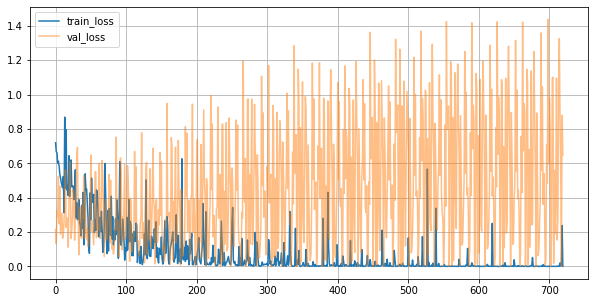

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss', alpha=0.5)
plt.legend(loc='best')
plt.grid()

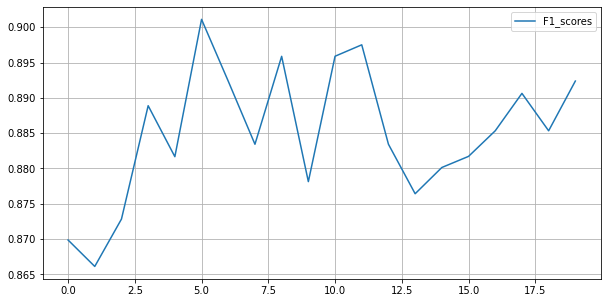

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(F1_scores, label='F1_scores')
plt.legend(loc='best')
plt.grid()

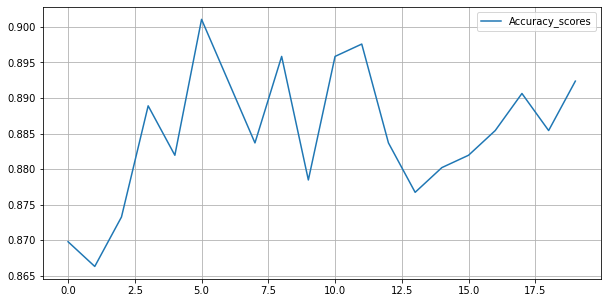

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(accuracy_scores, label='Accuracy_scores')
plt.legend(loc='best')
plt.grid()

# Simple approaches

In [ ]:
import nltk
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

def prepocess_news( raw_text ):

    reg = re.compile('[^а-яА-яa-zA-Z0-9 ]') 
    text = raw_text.lower().replace("ё", "е")
    text = text.replace("ъ", "ь")
    text = text.replace("й", "и")
    text = reg.sub(' ', text)
    stemmer = SnowballStemmer("russian")
    stops = set(stopwords.words("russian"))             
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stops])

    return(text)  

In [ ]:
print(f"Sample before: {train_df['title'][0]}")
cleaned_sample = prepocess_news( train_df['title'][0] )
print(f"Sample after: {cleaned_sample}")

Sample before: Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы
Sample after: москвич владимир клутин пришел счет вмешательств американск выбор


In [ ]:
%time 
train_df['title'] = train_df['title'].apply(prepocess_news)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


In [ ]:
train_df['title'][0]

'москвич владимир клутин пришел счет вмешательств американск выбор'

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_val, targets_train, targets_val = train_test_split(
    train_df['title'], 
    train_df['is_fake'], 
    test_size=.1, 
    random_state=42,
)

In [ ]:
print(df_train.shape, df_val.shape)

(5182,) (576,)


## Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 2))

train_BoW_features = vectorizer.fit_transform(df_train)
test_BoW_features = vectorizer.transform(df_val)

print(train_BoW_features.shape, test_BoW_features.shape)

(5182, 39650) (576, 39650)


In [ ]:
clf = LogisticRegression(random_state=42)
clf.fit(train_BoW_features, targets_train)

LogisticRegression(random_state=42)

In [ ]:
predicted_labels = clf.predict(test_BoW_features)

print(f"Accuracy = {accuracy_score(predicted_labels, targets_val)}; F1 = {accuracy_score(predicted_labels, targets_val)}")

Accuracy = 0.8489583333333334; F1 = 0.8489583333333334


              precision    recall  f1-score   support

           0       0.80      0.90      0.85       272
           1       0.90      0.80      0.85       304

    accuracy                           0.85       576
   macro avg       0.85      0.85      0.85       576
weighted avg       0.85      0.85      0.85       576

AxesSubplot(0.125,0.125;0.62x0.755)


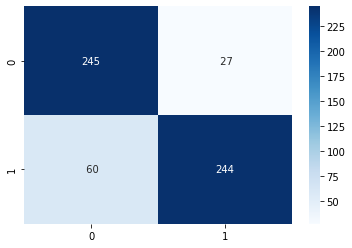

In [ ]:
print(classification_report(targets_val, predicted_labels))
print(sns.heatmap(confusion_matrix(targets_val, predicted_labels), annot=True, cmap='Blues', fmt='3g'))

### Fine-tuning hyperparameters

In [ ]:
grid = {
    "C":[1e-2, 0.1, 1, 10, 100], 
    "penalty":["l1", "l2"],
    "solver":['liblinear', 'newton-cg', 'lbfgs']
}

clf = LogisticRegression()
grid_search = GridSearchCV(clf, grid, cv=5) # KFold with 5 folds
grid_search.fit(train_BoW_features, targets_train)

print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.8419544423883863


In [ ]:
clf = LogisticRegression(C=10, penalty="l2",solver="liblinear")
clf.fit(train_BoW_features, targets_train)

LogisticRegression(C=10, solver='liblinear')

In [ ]:
predicted_labels = clf.predict(test_BoW_features)

print(f"Accuracy = {accuracy_score(predicted_labels, targets_val)}; F1 = {accuracy_score(predicted_labels, targets_val)}")
# стало хуже

Accuracy = 0.8420138888888888; F1 = 0.8420138888888888


              precision    recall  f1-score   support

           0       0.79      0.90      0.84       272
           1       0.90      0.79      0.84       304

    accuracy                           0.84       576
   macro avg       0.85      0.84      0.84       576
weighted avg       0.85      0.84      0.84       576

AxesSubplot(0.125,0.125;0.62x0.755)


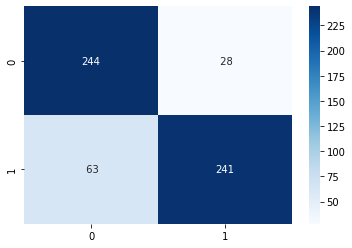

In [ ]:
print(classification_report(targets_val, predicted_labels))
print(sns.heatmap(confusion_matrix(targets_val, predicted_labels), annot=True, cmap='Blues', fmt='3g'))

### RandomForest (600 trees ensemble)

In [ ]:
%%time

clf = RandomForestClassifier(n_estimators = 600) 

clf.fit(train_BoW_features, targets_train)

CPU times: user 45 s, sys: 0 ns, total: 45 s
Wall time: 51.9 s


In [ ]:
predicted_labels = clf.predict(test_BoW_features)

print(f"Accuracy = {accuracy_score(predicted_labels, targets_val)}; F1 = {accuracy_score(predicted_labels, targets_val)}")

Accuracy = 0.7881944444444444; F1 = 0.7881944444444444


              precision    recall  f1-score   support

           0       0.70      0.95      0.81       272
           1       0.94      0.64      0.76       304

    accuracy                           0.79       576
   macro avg       0.82      0.80      0.79       576
weighted avg       0.83      0.79      0.78       576

AxesSubplot(0.125,0.125;0.62x0.755)


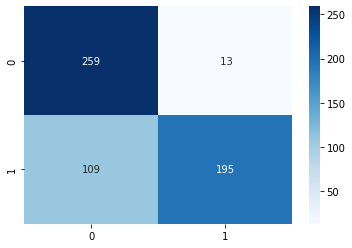

In [ ]:
print(classification_report(targets_val, predicted_labels))
print(sns.heatmap(confusion_matrix(targets_val, predicted_labels), annot=True, cmap='Blues', fmt='3g'))

## Tf-idf

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

train_BoW_features = vectorizer.fit_transform(df_train)
test_BoW_features = vectorizer.transform(df_val)

print(train_BoW_features.shape, test_BoW_features.shape)

(5182, 39650) (576, 39650)


In [ ]:
clf = LogisticRegression(random_state=42)
clf.fit(train_BoW_features, targets_train)

LogisticRegression(random_state=42)

In [ ]:
predicted_labels = clf.predict(test_BoW_features)

print(f"Accuracy = {accuracy_score(predicted_labels, targets_val)}; F1 = {accuracy_score(predicted_labels, targets_val)}")

Accuracy = 0.8576388888888888; F1 = 0.8576388888888888


              precision    recall  f1-score   support

           0       0.85      0.84      0.85       272
           1       0.86      0.87      0.87       304

    accuracy                           0.86       576
   macro avg       0.86      0.86      0.86       576
weighted avg       0.86      0.86      0.86       576

AxesSubplot(0.125,0.125;0.62x0.755)


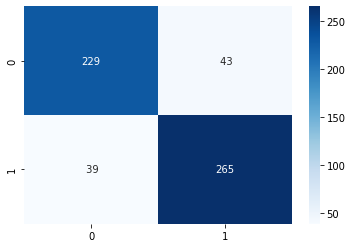

In [ ]:
print(classification_report(targets_val, predicted_labels))
print(sns.heatmap(confusion_matrix(targets_val, predicted_labels), annot=True, cmap='Blues', fmt='3g'))

### Fine-tuning hyperparameters

In [ ]:
grid = {
    "C":[1e-2, 0.1, 1, 10, 100], 
    "penalty":["l1", "l2"],
    "solver":['liblinear', 'newton-cg', 'lbfgs']
}

clf = LogisticRegression()
grid_search = GridSearchCV(clf, grid, cv=5) # KFold with 5 folds
grid_search.fit(train_BoW_features, targets_train)

print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.841758972086841


In [ ]:
clf = LogisticRegression(C=10, penalty="l2",solver="liblinear")
clf.fit(train_BoW_features, targets_train)

LogisticRegression(C=10, solver='liblinear')

In [ ]:
predicted_labels = clf.predict(test_BoW_features)

print(f"Accuracy = {accuracy_score(predicted_labels, targets_val)}; F1 = {accuracy_score(predicted_labels, targets_val)}")

Accuracy = 0.8541666666666666; F1 = 0.8541666666666666


              precision    recall  f1-score   support

           0       0.86      0.83      0.84       272
           1       0.85      0.88      0.86       304

    accuracy                           0.85       576
   macro avg       0.85      0.85      0.85       576
weighted avg       0.85      0.85      0.85       576

AxesSubplot(0.125,0.125;0.62x0.755)


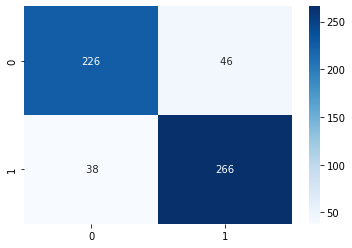

In [ ]:
print(classification_report(targets_val, predicted_labels))
print(sns.heatmap(confusion_matrix(targets_val, predicted_labels), annot=True, cmap='Blues', fmt='3g'))

### RandomForest (600 trees ensemble)

In [ ]:
%%time

clf = RandomForestClassifier(n_estimators = 600) 

clf.fit(train_BoW_features, targets_train)

CPU times: user 32.9 s, sys: 5.44 ms, total: 32.9 s
Wall time: 33.7 s


In [ ]:
predicted_labels = clf.predict(test_BoW_features)

print(f"Accuracy = {accuracy_score(predicted_labels, targets_val)}; F1 = {accuracy_score(predicted_labels, targets_val)}")

Accuracy = 0.7534722222222222; F1 = 0.7534722222222222


              precision    recall  f1-score   support

           0       0.67      0.96      0.79       272
           1       0.94      0.57      0.71       304

    accuracy                           0.75       576
   macro avg       0.80      0.76      0.75       576
weighted avg       0.81      0.75      0.75       576

AxesSubplot(0.125,0.125;0.62x0.755)


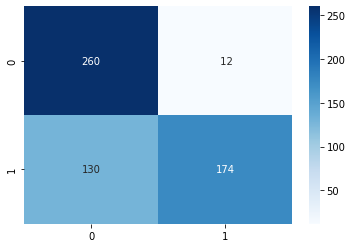

In [ ]:
print(classification_report(targets_val, predicted_labels))
print(sns.heatmap(confusion_matrix(targets_val, predicted_labels), annot=True, cmap='Blues', fmt='3g'))